## The Problem Definition

The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information

#### Additional Information

Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes. 
The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information. 

https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand



In [1]:
# importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import chardet
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from powerbiclient import Report, models


In [2]:
pip install powerbiclient

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


###### Uploading the data

In [3]:
# uploading data
path = "seoul_bike_sharing_demand\SeoulBikeData.csv"

In [4]:
df_seoulbike = pd.read_csv(path)

In [5]:
df_seoulbike

,Date,Rented Bike Count,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


# Preprocessing

## __Finding out the enconding type__

In [6]:
#Let's clean the varible's names to work with it.
df_seoulbike.columns.to_list()

['Date',
 'Rented Bike Count',
 'Hour',
 'Temperature(�C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(�C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Seasons',
 'Holiday',
 'Functioning Day']

In [7]:
#Ok we have a little suprise here. The symbol �, I don't know o que that means. 
#So I had to findout what is this to work with pandas.
#So I will use the chardet library to help me with this.
with open(path, 'rb') as encoding:
    r_encoding = chardet.detect(encoding.read(100000))
r_encoding


{'encoding': 'ISO-8859-9',
 'confidence': 0.7396635956274547,
 'language': 'Turkish'}

In [8]:
# Good, now I will open the as a dataframe with the right encoding.
with open (path,'r',encoding=r_encoding['encoding']) as df_seoulbike:
    df_seoulbike= pd.read_csv(df_seoulbike)

In [9]:
df_seoulbike.columns.to_list()

['Date',
 'Rented Bike Count',
 'Hour',
 'Temperature(°C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(°C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Seasons',
 'Holiday',
 'Functioning Day']

## __Cleaning the column's name__

In [10]:
#Building a function to clean the columns name. Taking out the space and putting all in lower case:
replacing1= {" ":"_"}


cols = [col.strip().lower().replace(" ","_")
       for col in df_seoulbike.columns]

df_seoulbike.columns = cols
df_seoulbike.columns.to_list()

['date',
 'rented_bike_count',
 'hour',
 'temperature(°c)',
 'humidity(%)',
 'wind_speed_(m/s)',
 'visibility_(10m)',
 'dew_point_temperature(°c)',
 'solar_radiation_(mj/m2)',
 'rainfall(mm)',
 'snowfall_(cm)',
 'seasons',
 'holiday',
 'functioning_day']

## __Cheking the shape and looking for NAN values__

In [11]:
#Let's check the shape of the dataset
initial_shape = df_seoulbike.shape
initial_shape

(8760, 14)

In [12]:
#Good, Now let's see if we have some missing values.
# So I can do it with a isnan function
df_seoulbike.isna().sum()

date                         0
rented_bike_count            0
hour                         0
temperature(°c)              0
humidity(%)                  0
wind_speed_(m/s)             0
visibility_(10m)             0
dew_point_temperature(°c)    0
solar_radiation_(mj/m2)      0
rainfall(mm)                 0
snowfall_(cm)                0
seasons                      0
holiday                      0
functioning_day              0
dtype: int64

<AxesSubplot:>

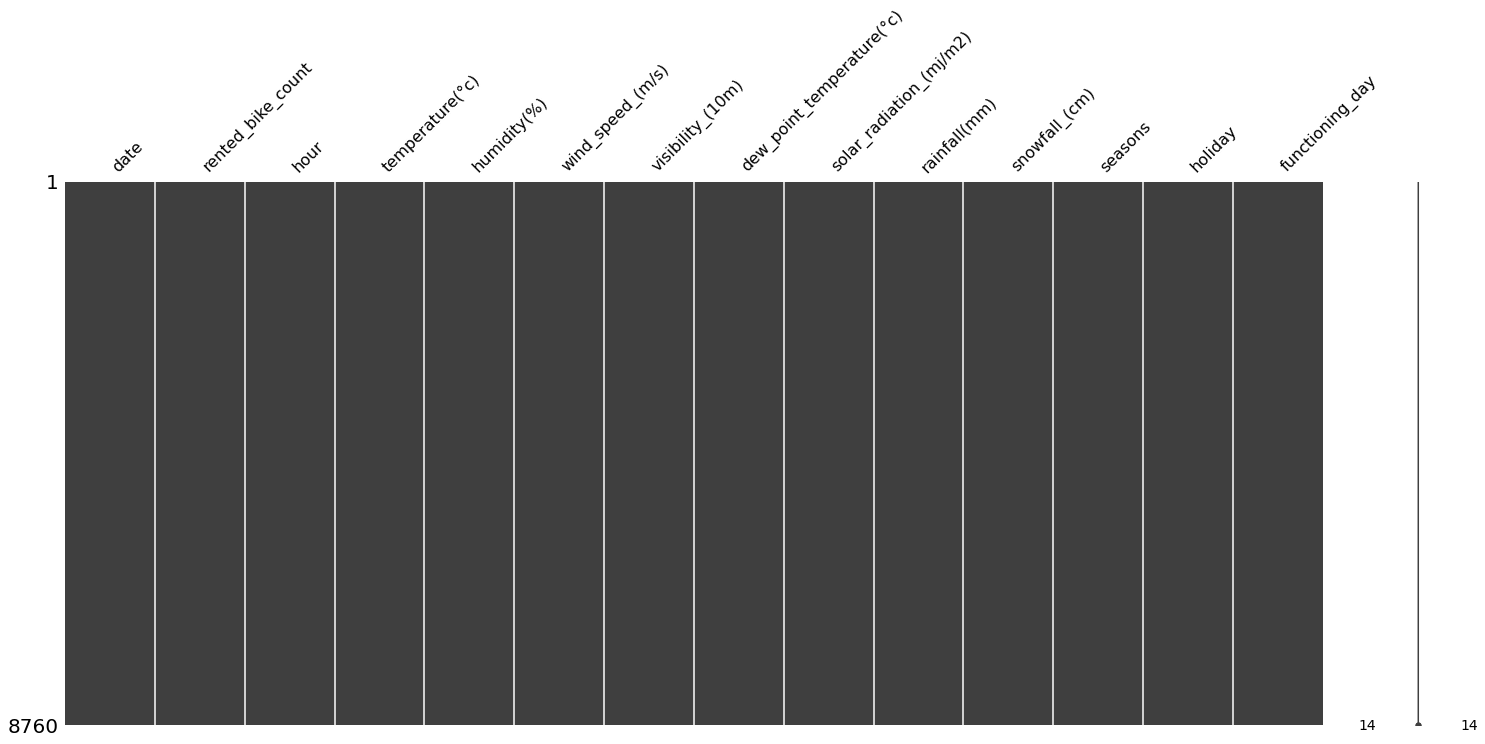

In [13]:
#I could also check it with a missingno library
msno.matrix(df_seoulbike)

## __Checking the data type and casting it if necessary__

In [14]:
#Ok really no missing values
#Let's ckeck the type of columns do we have
df_seoulbike.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       8760 non-null   object 
 1   rented_bike_count          8760 non-null   int64  
 2   hour                       8760 non-null   int64  
 3   temperature(°c)            8760 non-null   float64
 4   humidity(%)                8760 non-null   int64  
 5   wind_speed_(m/s)           8760 non-null   float64
 6   visibility_(10m)           8760 non-null   int64  
 7   dew_point_temperature(°c)  8760 non-null   float64
 8   solar_radiation_(mj/m2)    8760 non-null   float64
 9   rainfall(mm)               8760 non-null   float64
 10  snowfall_(cm)              8760 non-null   float64
 11  seasons                    8760 non-null   object 
 12  holiday                    8760 non-null   object 
 13  functioning_day            8760 non-null   objec

In [15]:
df_seoulbike.dtypes

date                          object
rented_bike_count              int64
hour                           int64
temperature(°c)              float64
humidity(%)                    int64
wind_speed_(m/s)             float64
visibility_(10m)               int64
dew_point_temperature(°c)    float64
solar_radiation_(mj/m2)      float64
rainfall(mm)                 float64
snowfall_(cm)                float64
seasons                       object
holiday                       object
functioning_day               object
dtype: object

In [16]:
int_type = df_seoulbike.select_dtypes(include = "integer").columns.to_list()
float_type = df_seoulbike.select_dtypes(include = "float").columns.to_list()
object_type = df_seoulbike.select_dtypes(include = "object").columns.to_list()

print("The int columns type: ")
int_type



The int columns type: 


['rented_bike_count', 'hour', 'humidity(%)', 'visibility_(10m)']

In [17]:
df_seoulbike.select_dtypes(include = "integer")

,rented_bike_count,hour,humidity(%),visibility_(10m)
0,254,0,37,2000
1,204,1,38,2000
2,173,2,39,2000
3,107,3,40,2000
4,78,4,36,2000
...,...,...,...,...
8755,1003,19,34,1894
8756,764,20,37,2000
8757,694,21,39,1968
8758,712,22,41,1859


In [18]:
print("The float columns type: ")
float_type

The float columns type: 


['temperature(°c)',
 'wind_speed_(m/s)',
 'dew_point_temperature(°c)',
 'solar_radiation_(mj/m2)',
 'rainfall(mm)',
 'snowfall_(cm)']

In [19]:
df_seoulbike.select_dtypes(include = "float")

,temperature(°c),wind_speed_(m/s),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm)
0,-5.2,2.2,-17.6,0.0,0.0,0.0
1,-5.5,0.8,-17.6,0.0,0.0,0.0
2,-6.0,1.0,-17.7,0.0,0.0,0.0
3,-6.2,0.9,-17.6,0.0,0.0,0.0
4,-6.0,2.3,-18.6,0.0,0.0,0.0
...,...,...,...,...,...,...
8755,4.2,2.6,-10.3,0.0,0.0,0.0
8756,3.4,2.3,-9.9,0.0,0.0,0.0
8757,2.6,0.3,-9.9,0.0,0.0,0.0
8758,2.1,1.0,-9.8,0.0,0.0,0.0


In [20]:
print("The object columns type: ")
object_type

The object columns type: 


['date', 'seasons', 'holiday', 'functioning_day']

In [21]:
df_seoulbike.select_dtypes(include = "object")

,date,seasons,holiday,functioning_day
0,01/12/2017,Winter,No Holiday,Yes
1,01/12/2017,Winter,No Holiday,Yes
2,01/12/2017,Winter,No Holiday,Yes
3,01/12/2017,Winter,No Holiday,Yes
4,01/12/2017,Winter,No Holiday,Yes
...,...,...,...,...
8755,30/11/2018,Autumn,No Holiday,Yes
8756,30/11/2018,Autumn,No Holiday,Yes
8757,30/11/2018,Autumn,No Holiday,Yes
8758,30/11/2018,Autumn,No Holiday,Yes


In [22]:
#Hun I'm not sure we need use float64 in all float types. Maybe we can improve it.
#Let's ckeck the usage of all memory.
first_memory_usage = df_seoulbike.memory_usage(deep=True)
first_memory_usage

Index                           128
date                         586920
rented_bike_count             70080
hour                          70080
temperature(°c)               70080
humidity(%)                   70080
wind_speed_(m/s)              70080
visibility_(10m)              70080
dew_point_temperature(°c)     70080
solar_radiation_(mj/m2)       70080
rainfall(mm)                  70080
snowfall_(cm)                 70080
seasons                      551880
holiday                      585624
functioning_day              525305
dtype: int64

#### Ok now we know the type of columns we are working with. Let's casting some of then and create other ones.


In [23]:


class Treating_data:
    '''
    A class to cast the datetypes and to create new columns date type.. 
    Changing the data type, creating new date columns information and changing the new columns date type.
    '''
    
    def __init__(self, df_bike):
        '''
        Creating the sequence of treating to data.
        '''
        self.df_bike = df_bike
        self.changing_type(self.df_bike)
        self.creating_date_info(self.df_bike)
        self.changing_type_after_date_info(self.df_bike)
        self.changing_to_binary_column(self.df_bike)


    def changing_type(self,df_seoulbike):
        '''
        A functon to change the size of float type, 
        to create a column to datetime type and change object type to category type.
        '''
        for coluna in df_seoulbike.columns:
            if "temperature" in coluna:
                df_seoulbike[coluna] = df_seoulbike[coluna].astype("float16")
            elif "date" in coluna:
                df_seoulbike[coluna] = pd.to_datetime(arg=df_seoulbike[coluna],format= "%d/%m/%Y")
            elif coluna in ['seasons','holiday','functioning_day']:
                df_seoulbike[coluna] = df_seoulbike[coluna].astype("category")
        return  df_seoulbike


    def creating_date_info(self,df_seoulbike):
        '''
        A function to create date type columns.
        '''
        df_seoulbike['day_of_week'] =df_seoulbike['date'].dt.day_name() 
        df_seoulbike['year'] = df_seoulbike['date'].dt.year
        df_seoulbike['month'] = df_seoulbike['date'].dt.month #I need this feature to stratify during the train and test moment
        #df_seoulbike['day_of_year'] = df_seoulbike['date'].dt.dayofyear
        df_seoulbike['week_of_year'] = df_seoulbike['date'].dt.isocalendar().week
        #df_seoulbike['month_name'] = df_seoulbike['date'].dt.month_name()
        #df_seoulbike['period_day'] = df_seoulbike['date'].dt.strftime('%a')
        df_seoulbike['month_name'] = df_seoulbike['date'].dt.strftime('%b')
        return  df_seoulbike

    def changing_type_after_date_info(self,df_seoulbike):
        '''
        A function to change as category the columns object types of date 
        '''
        for coluna in df_seoulbike.columns:
            if coluna in ['day_of_week','year','month','week_of_year', 'month_name','hour']:
                df_seoulbike[coluna] = df_seoulbike[coluna].astype("category")
        return  df_seoulbike
    
    def changing_to_binary_column(self,df_seoulbike):
        '''
        A function to turne coluns as binary one
        '''
        df_seoulbike["holiday"] = df_seoulbike["holiday"].map({"No Holiday":0,"Holiday":1})
        df_seoulbike["functioning_day"] = df_seoulbike["functioning_day"].map({"No" : 0, "Yes":1})


In [24]:
df_seoulbike = Treating_data(df_seoulbike)

In [25]:
df_seoulbike.df_bike

,date,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),seasons,holiday,functioning_day,day_of_week,year,month,week_of_year,month_name
0,2017-12-01,254,0,-5.199219,37,2.2,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
1,2017-12-01,204,1,-5.500000,38,0.8,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
2,2017-12-01,173,2,-6.000000,39,1.0,2000,-17.703125,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
3,2017-12-01,107,3,-6.199219,40,0.9,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
4,2017-12-01,78,4,-6.000000,36,2.3,2000,-18.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,19,4.199219,34,2.6,1894,-10.296875,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov
8756,2018-11-30,764,20,3.400391,37,2.3,2000,-9.898438,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov
8757,2018-11-30,694,21,2.599609,39,0.3,1968,-9.898438,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov
8758,2018-11-30,712,22,2.099609,41,1.0,1859,-9.796875,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov


In [26]:
df_seoulbike_treated = df_seoulbike.df_bike

In [27]:
df_seoulbike_treated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       8760 non-null   datetime64[ns]
 1   rented_bike_count          8760 non-null   int64         
 2   hour                       8760 non-null   category      
 3   temperature(°c)            8760 non-null   float16       
 4   humidity(%)                8760 non-null   int64         
 5   wind_speed_(m/s)           8760 non-null   float64       
 6   visibility_(10m)           8760 non-null   int64         
 7   dew_point_temperature(°c)  8760 non-null   float16       
 8   solar_radiation_(mj/m2)    8760 non-null   float64       
 9   rainfall(mm)               8760 non-null   float64       
 10  snowfall_(cm)              8760 non-null   float64       
 11  seasons                    8760 non-null   category      
 12  holida

In [28]:
df_seoulbike_treated.describe()

,rented_bike_count,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,inf,58.226256,1.724909,1436.825799,4.074219,0.569111,0.148687,0.075068
std,644.997468,11.945312,20.362413,1.036300,608.298712,13.054688,0.868746,1.128193,0.436746
min,0.000000,-17.796875,0.000000,0.000000,27.000000,-30.593750,0.000000,0.000000,0.000000
25%,191.000000,3.500000,42.000000,0.900000,940.000000,-4.699219,0.000000,0.000000,0.000000
50%,504.500000,13.703125,57.000000,1.500000,1698.000000,5.101562,0.010000,0.000000,0.000000
75%,1065.250000,22.500000,74.000000,2.300000,2000.000000,14.796875,0.930000,0.000000,0.000000
max,3556.000000,39.406250,98.000000,7.400000,2000.000000,27.203125,3.520000,35.000000,8.800000


In [29]:
df_seoulbike_treated.shape

(8760, 19)

In [30]:
df_categorical_columns = df_seoulbike_treated.select_dtypes(include = "category")
df_categorical_columns 

,hour,seasons,holiday,functioning_day,day_of_week,year,month,week_of_year,month_name
0,0,Winter,0,1,Friday,2017,12,48,Dec
1,1,Winter,0,1,Friday,2017,12,48,Dec
2,2,Winter,0,1,Friday,2017,12,48,Dec
3,3,Winter,0,1,Friday,2017,12,48,Dec
4,4,Winter,0,1,Friday,2017,12,48,Dec
...,...,...,...,...,...,...,...,...,...
8755,19,Autumn,0,1,Friday,2018,11,48,Nov
8756,20,Autumn,0,1,Friday,2018,11,48,Nov
8757,21,Autumn,0,1,Friday,2018,11,48,Nov
8758,22,Autumn,0,1,Friday,2018,11,48,Nov


In [31]:
categorical_columns = df_categorical_columns.columns

In [32]:
categorical_columns

Index(['hour', 'seasons', 'holiday', 'functioning_day', 'day_of_week', 'year',
       'month', 'week_of_year', 'month_name'],
      dtype='object')

In [33]:
df_seoulbike_treated

,date,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),seasons,holiday,functioning_day,day_of_week,year,month,week_of_year,month_name
0,2017-12-01,254,0,-5.199219,37,2.2,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
1,2017-12-01,204,1,-5.500000,38,0.8,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
2,2017-12-01,173,2,-6.000000,39,1.0,2000,-17.703125,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
3,2017-12-01,107,3,-6.199219,40,0.9,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
4,2017-12-01,78,4,-6.000000,36,2.3,2000,-18.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,19,4.199219,34,2.6,1894,-10.296875,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov
8756,2018-11-30,764,20,3.400391,37,2.3,2000,-9.898438,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov
8757,2018-11-30,694,21,2.599609,39,0.3,1968,-9.898438,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov
8758,2018-11-30,712,22,2.099609,41,1.0,1859,-9.796875,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov


In [34]:
df_seoulbike_treated['year'].unique()

[2017, 2018]
Categories (2, int64): [2017, 2018]

In [35]:
df_seoulbike_treated = df_seoulbike_treated.drop(["date"],axis=1, inplace=False)

In [36]:
#Checking all the columns type
df_seoulbike_treated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   rented_bike_count          8760 non-null   int64   
 1   hour                       8760 non-null   category
 2   temperature(°c)            8760 non-null   float16 
 3   humidity(%)                8760 non-null   int64   
 4   wind_speed_(m/s)           8760 non-null   float64 
 5   visibility_(10m)           8760 non-null   int64   
 6   dew_point_temperature(°c)  8760 non-null   float16 
 7   solar_radiation_(mj/m2)    8760 non-null   float64 
 8   rainfall(mm)               8760 non-null   float64 
 9   snowfall_(cm)              8760 non-null   float64 
 10  seasons                    8760 non-null   category
 11  holiday                    8760 non-null   category
 12  functioning_day            8760 non-null   category
 13  day_of_week                8760 n

## __Exploring the Data__

In [37]:
df_seoulbike_treated.head(7)

,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),seasons,holiday,functioning_day,day_of_week,year,month,week_of_year,month_name
0,254,0,-5.199219,37,2.2,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
1,204,1,-5.500000,38,0.8,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
2,173,2,-6.000000,39,1.0,2000,-17.703125,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
3,107,3,-6.199219,40,0.9,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
4,78,4,-6.000000,36,2.3,2000,-18.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
5,100,5,-6.398438,37,1.5,2000,-18.703125,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
6,181,6,-6.601562,35,1.3,2000,-19.500000,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec


In [38]:
df_seoulbike_treated.describe()

,rented_bike_count,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,inf,58.226256,1.724909,1436.825799,4.074219,0.569111,0.148687,0.075068
std,644.997468,11.945312,20.362413,1.036300,608.298712,13.054688,0.868746,1.128193,0.436746
min,0.000000,-17.796875,0.000000,0.000000,27.000000,-30.593750,0.000000,0.000000,0.000000
25%,191.000000,3.500000,42.000000,0.900000,940.000000,-4.699219,0.000000,0.000000,0.000000
50%,504.500000,13.703125,57.000000,1.500000,1698.000000,5.101562,0.010000,0.000000,0.000000
75%,1065.250000,22.500000,74.000000,2.300000,2000.000000,14.796875,0.930000,0.000000,0.000000
max,3556.000000,39.406250,98.000000,7.400000,2000.000000,27.203125,3.520000,35.000000,8.800000


In [39]:
# Import the DeviceCodeLoginAuthentication class to authenticate against Power BI
from powerbiclient.authentication import DeviceCodeLoginAuthentication

# Initiate device authentication
device_auth = DeviceCodeLoginAuthentication()

Performing device flow authentication. Please follow the instructions below.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code BFD4R9868 to authenticate.

Device flow authentication successfully completed.
You are now logged in .

The result should be passed only to trusted code in your notebook.


In [40]:

report_id = "f1d65d72-5b7b-4f17-9913-b4b2593e4e0a"


In [41]:
report = Report(report_id=report_id, auth=device_auth)

report

Report()

In [42]:
df_seoulbike_treated['month_name'].unique()

['Dec', 'Jan', 'Feb', 'Mar', 'Apr', ..., 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
Length: 12
Categories (12, object): ['Dec', 'Jan', 'Feb', 'Mar', ..., 'Aug', 'Sep', 'Oct', 'Nov']

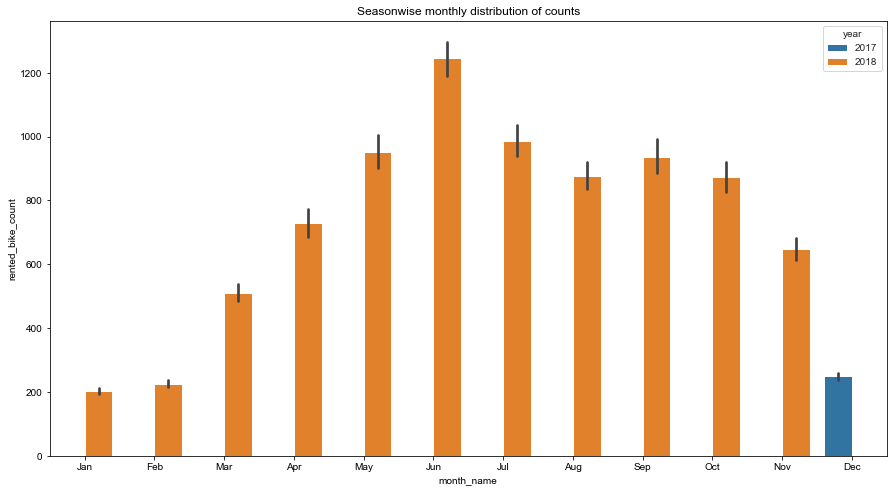

In [43]:
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='month_name',y='rented_bike_count',data=df_seoulbike_treated[['month_name','rented_bike_count','year']],hue='year',order=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec'],ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()

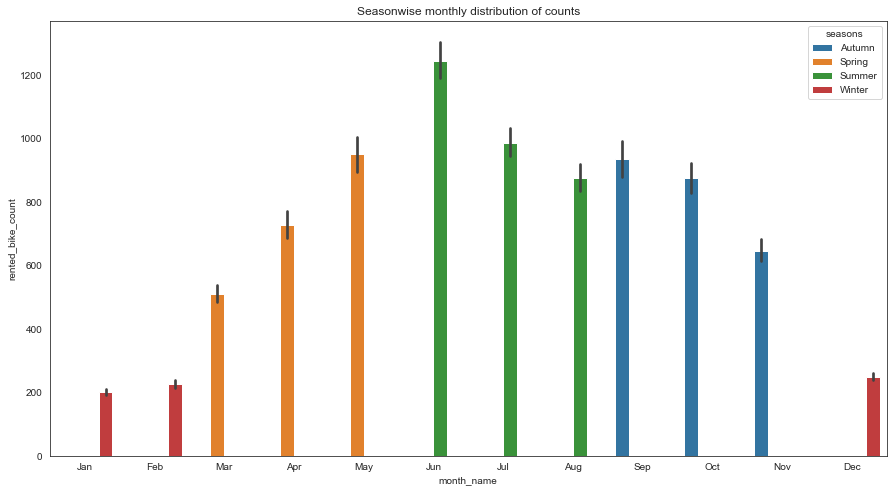

In [44]:
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='month_name',y='rented_bike_count',data=df_seoulbike_treated[['month_name','rented_bike_count','seasons']],hue='seasons',order=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec'],ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()

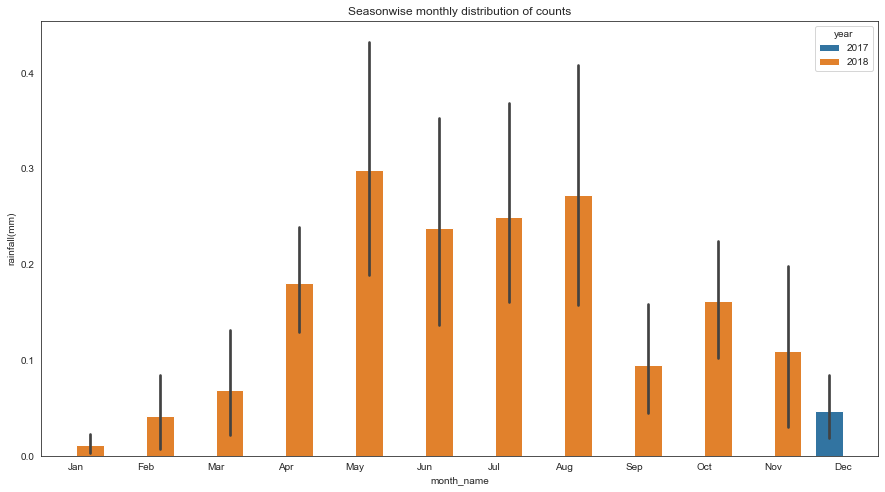

In [45]:


fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='month_name',y='rainfall(mm)',data=df_seoulbike_treated[['month_name','rainfall(mm)','year']],hue='year',order=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec'],ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()

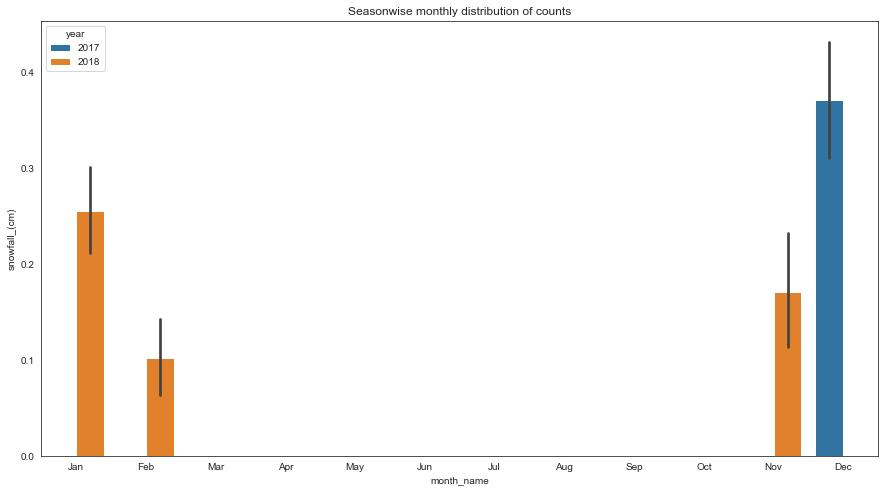

In [46]:

fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='month_name',y='snowfall_(cm)',data=df_seoulbike_treated[['month_name','snowfall_(cm)','year']],hue='year',order=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec'],ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()

## Finding Outliers

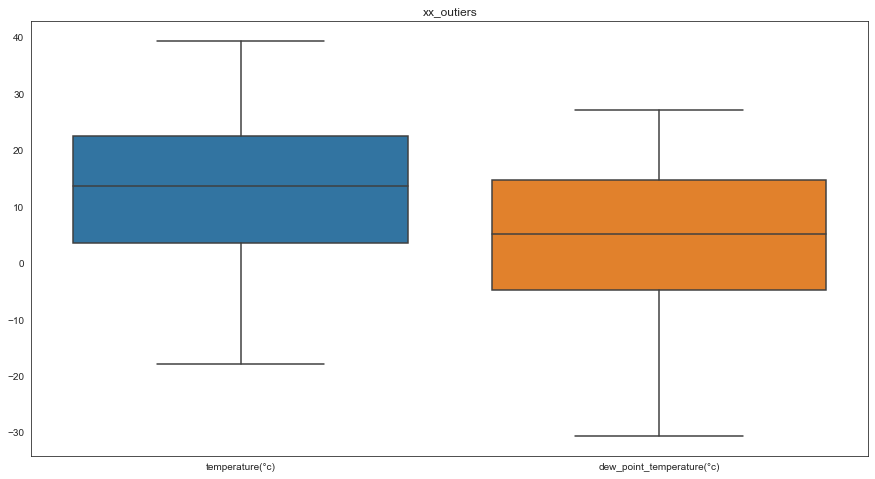

In [47]:
celsius = []
for mensure in float_type:
    if '(°c)' in mensure:
        celsius.append(mensure)
fig,ax=plt.subplots(figsize=(15,8))
#Box plot for xxx _outliers
sns.boxplot(data=df_seoulbike_treated[celsius])
ax.set_title('xx_outiers')
plt.show()

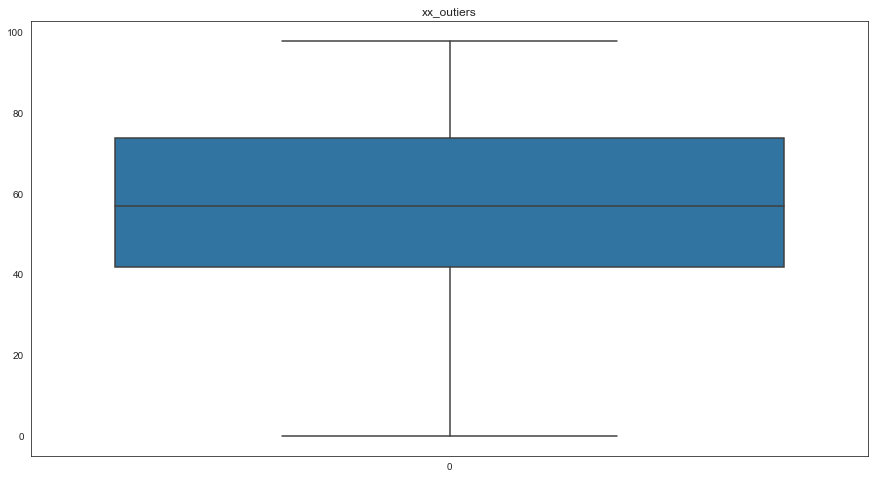

In [48]:

fig,ax=plt.subplots(figsize=(15,8))
#Box plot for xxx _outliers
sns.boxplot(data=df_seoulbike_treated['humidity(%)'])
ax.set_title('xx_outiers')
plt.show()

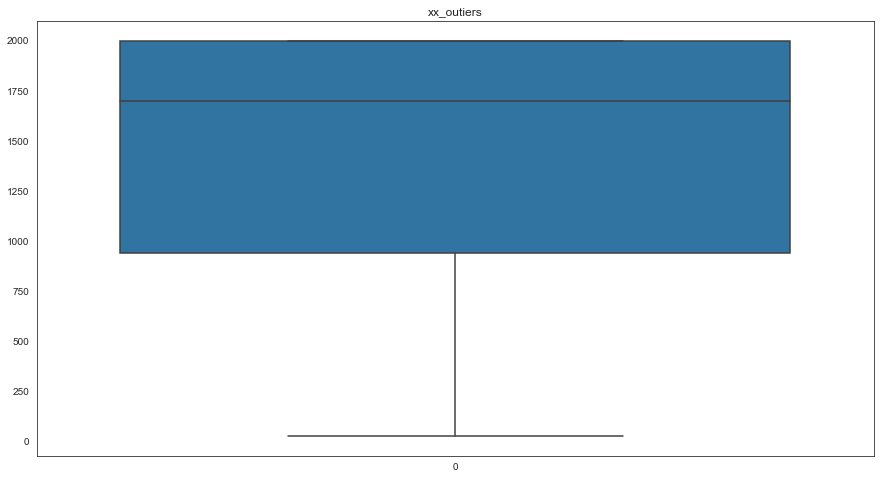

In [49]:



fig,ax=plt.subplots(figsize=(15,8))
#Box plot for xxx _outliers
sns.boxplot(data=df_seoulbike_treated['visibility_(10m)'])
ax.set_title('xx_outiers')
plt.show()

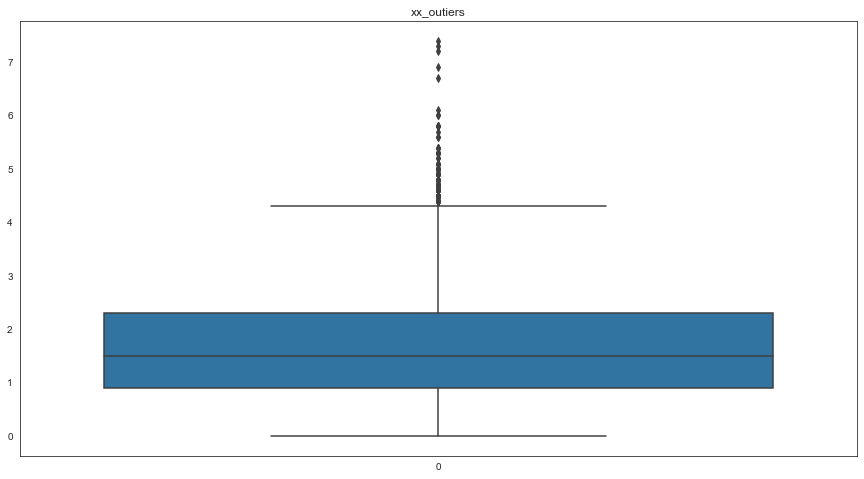

In [50]:


fig,ax=plt.subplots(figsize=(15,8))
#Box plot for xxx _outliers
sns.boxplot(data=df_seoulbike_treated['wind_speed_(m/s)'])
ax.set_title('xx_outiers')
plt.show()

In [51]:
df_seoulbike_treated['wind_speed_(m/s)'].describe()

count    8760.000000
mean        1.724909
std         1.036300
min         0.000000
25%         0.900000
50%         1.500000
75%         2.300000
max         7.400000
Name: wind_speed_(m/s), dtype: float64

In [52]:
wind_speed_Q1 = df_seoulbike_treated['wind_speed_(m/s)'].quantile(0.25)
wind_speed_Q3 = df_seoulbike_treated['wind_speed_(m/s)'].quantile(0.75)

print(f"The first Quantile of Wind_Speed is {wind_speed_Q1}")
print(f"The Thrid Quantile of Wind_Speed is {wind_speed_Q3}")

The first Quantile of Wind_Speed is 0.9
The Thrid Quantile of Wind_Speed is 2.3


In [53]:
wind_speed_IQR = wind_speed_Q3-wind_speed_Q1
wind_speed_IQR

1.4

### Calculating the Mild Outliers

In [54]:
#Calculating the Mild Outliers

mild_lower_bound = wind_speed_Q1-(1.5 * wind_speed_IQR)
mild_upper_bound = wind_speed_Q3+(1.5 * wind_speed_IQR)
print(f"The Mild Lower Bound is {mild_lower_bound}")
print(f"The Mild Upper Bound is {mild_upper_bound}")

The Mild Lower Bound is -1.1999999999999997
The Mild Upper Bound is 4.3999999999999995


### Calculating the Extreme Outlier


In [55]:
extreme_lower_bound = wind_speed_Q1-(3 * wind_speed_IQR)
extreme_upper_bound = wind_speed_Q3+(3 * wind_speed_IQR)
print(f"The Extreme Lower Bound is {extreme_lower_bound}")
print(f"The Extreme Upper Bound is {extreme_upper_bound}")

The Extreme Lower Bound is -3.2999999999999994
The Extreme Upper Bound is 6.499999999999999


In [56]:
outliers_lied_upper = df_seoulbike_treated['wind_speed_(m/s)']>mild_upper_bound

In [57]:
#Now let's determine the number of outlier thar are lie outside of the mild_upper_bound

number_of_outliers_lied_upper=(df_seoulbike_treated['wind_speed_(m/s)']>mild_upper_bound).sum()
number_of_outliers_lied_upper

161

In [58]:
#Calculating the percentage of wind_speed lied over the Mild Upper Bound
(df_seoulbike_treated['wind_speed_(m/s)']>mild_upper_bound).mean()*100

1.8378995433789953

In [59]:
#So now we'll identify which ones they are.
df_seoulbike_treated_wind_speed_lied_upper_outliers= df_seoulbike_treated[df_seoulbike_treated['wind_speed_(m/s)']>mild_upper_bound]
df_seoulbike_treated_wind_speed_lied_upper_outliers

,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),seasons,holiday,functioning_day,day_of_week,year,month,week_of_year,month_name
82,311,10,-1.099609,40,4.5,2000,-13.000000,0.64,0.0,0.0,Winter,0,1,Monday,2017,12,49,Dec
84,393,12,-0.300049,38,4.8,1823,-12.898438,1.11,0.0,0.0,Winter,0,1,Monday,2017,12,49,Dec
85,391,13,0.000000,30,5.4,1938,-15.500000,1.17,0.0,0.0,Winter,0,1,Monday,2017,12,49,Dec
86,338,14,0.099976,27,4.5,2000,-16.703125,1.09,0.0,0.0,Winter,0,1,Monday,2017,12,49,Dec
87,341,15,-0.099976,25,5.8,2000,-17.796875,0.88,0.0,0.0,Winter,0,1,Monday,2017,12,49,Dec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7934,1183,14,10.796875,37,4.4,2000,-3.300781,1.29,0.0,0.0,Autumn,0,1,Saturday,2018,10,43,Oct
7937,1176,17,9.500000,34,5.7,2000,-5.601562,0.45,0.0,0.0,Autumn,0,1,Saturday,2018,10,43,Oct
7985,1274,17,10.000000,43,4.9,2000,-2.000000,0.43,0.0,0.0,Autumn,0,1,Monday,2018,10,44,Oct
8242,0,10,11.296875,68,4.7,1984,5.500000,0.44,0.0,0.0,Autumn,0,0,Friday,2018,11,45,Nov


In [60]:
df_seoulbike_treated_wind_speed_lied_upper_outliers.describe()

,rented_bike_count,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm)
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,528.850932,7.507812,42.894410,4.885093,1661.136646,-5.292969,1.210621,0.154037,0.083230
std,470.221852,11.734375,19.641347,0.542127,509.133093,13.703125,1.025757,1.058654,0.250309
min,0.000000,-14.500000,14.000000,4.400000,214.000000,-30.593750,0.000000,0.000000,0.000000
25%,177.000000,-2.400391,30.000000,4.500000,1480.000000,-17.703125,0.170000,0.000000,0.000000
50%,302.000000,5.000000,37.000000,4.700000,1938.000000,-5.699219,1.090000,0.000000,0.000000
75%,931.000000,18.593750,52.000000,5.000000,2000.000000,4.898438,1.960000,0.000000,0.000000
max,2068.000000,33.312500,96.000000,7.400000,2000.000000,23.203125,3.320000,13.000000,1.000000


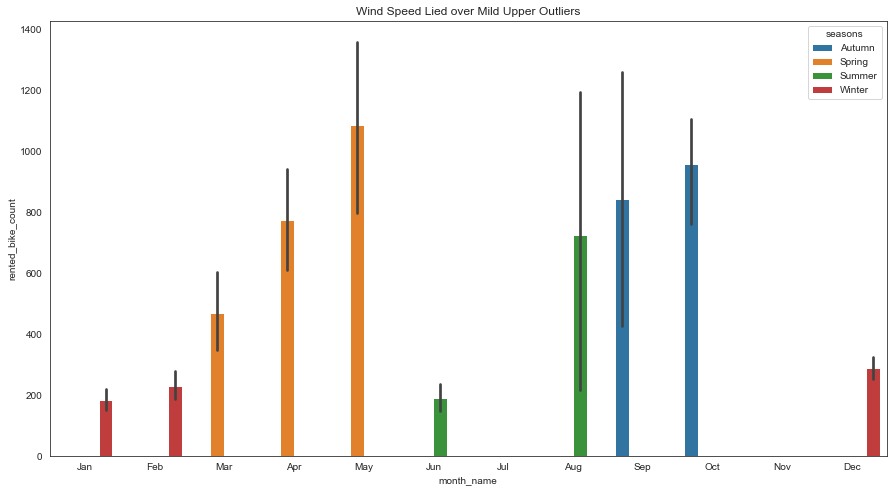

In [61]:
#let's see in which season that happened

fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='month_name',y='rented_bike_count',data=df_seoulbike_treated_wind_speed_lied_upper_outliers[['month_name','rented_bike_count','seasons']],hue='seasons',order=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec'],ax=ax)
ax.set_title('Wind Speed Lied over Mild Upper Outliers')
plt.show()

Ok that happened during all the year
OK I will replace the upper outliers with the mean valuers during each season

In [62]:
media_wind_speed=df_seoulbike_treated_wind_speed_lied_upper_outliers['wind_speed_(m/s)']
media_wind_speed = media_wind_speed.describe().values[1]
media_wind_speed

4.8850931677018625

In [63]:
df_seoulbike_treated_wind_speed_lied_upper_outliers_teste =df_seoulbike_treated_wind_speed_lied_upper_outliers.copy()

In [64]:


df_seoulbike_treated['wind_speed_(m/s)'] = np.where(df_seoulbike_treated['wind_speed_(m/s)']>mild_upper_bound,mild_upper_bound,df_seoulbike_treated['wind_speed_(m/s)'])

In [65]:
df_seoulbike_treated_wind_speed_lied_upper_outliers_teste['wind_speed_(m/s)']

82      4.5
84      4.8
85      5.4
86      4.5
87      5.8
       ... 
7934    4.4
7937    5.7
7985    4.9
8242    4.7
8245    5.3
Name: wind_speed_(m/s), Length: 161, dtype: float64

In [66]:
df_seoulbike_treated.describe()

,rented_bike_count,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,inf,58.226256,1.715993,1436.825799,4.074219,0.569111,0.148687,0.075068
std,644.997468,11.945312,20.362413,1.008186,608.298712,13.054688,0.868746,1.128193,0.436746
min,0.000000,-17.796875,0.000000,0.000000,27.000000,-30.593750,0.000000,0.000000,0.000000
25%,191.000000,3.500000,42.000000,0.900000,940.000000,-4.699219,0.000000,0.000000,0.000000
50%,504.500000,13.703125,57.000000,1.500000,1698.000000,5.101562,0.010000,0.000000,0.000000
75%,1065.250000,22.500000,74.000000,2.300000,2000.000000,14.796875,0.930000,0.000000,0.000000
max,3556.000000,39.406250,98.000000,4.400000,2000.000000,27.203125,3.520000,35.000000,8.800000


In [67]:
df_seoulbike_treated_wind_speed_lied_upper_outliers.iloc[82,4]

4.6

In [68]:
df_seoulbike_treated.iloc[82,4]

4.3999999999999995

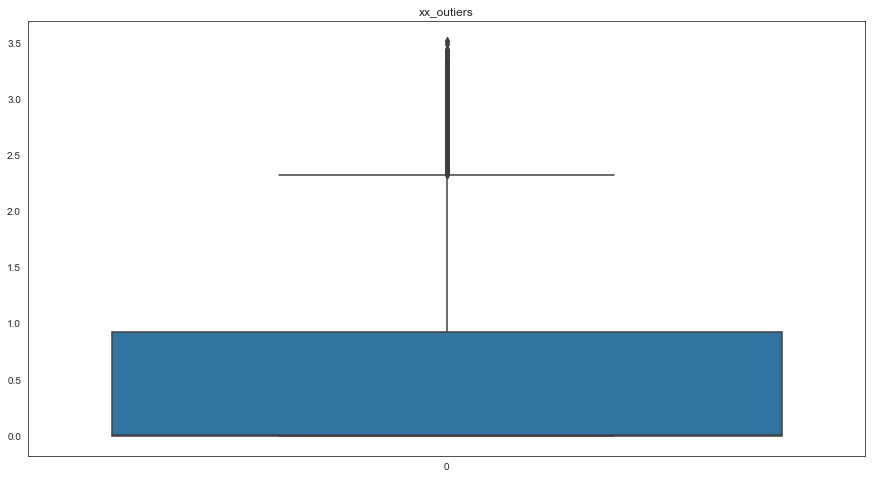

In [69]:


fig,ax=plt.subplots(figsize=(15,8))
#Box plot for xxx _outliers
sns.boxplot(data=df_seoulbike_treated['solar_radiation_(mj/m2)'])
ax.set_title('xx_outiers')
plt.show()

In [70]:
df_seoulbike_treated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   rented_bike_count          8760 non-null   int64   
 1   hour                       8760 non-null   category
 2   temperature(°c)            8760 non-null   float16 
 3   humidity(%)                8760 non-null   int64   
 4   wind_speed_(m/s)           8760 non-null   float64 
 5   visibility_(10m)           8760 non-null   int64   
 6   dew_point_temperature(°c)  8760 non-null   float16 
 7   solar_radiation_(mj/m2)    8760 non-null   float64 
 8   rainfall(mm)               8760 non-null   float64 
 9   snowfall_(cm)              8760 non-null   float64 
 10  seasons                    8760 non-null   category
 11  holiday                    8760 non-null   category
 12  functioning_day            8760 non-null   category
 13  day_of_week                8760 n

### df_seoulbike_treated

In [71]:
solar_radiation_Q1 = df_seoulbike_treated['solar_radiation_(mj/m2)'].quantile(0.25)
solar_radiation_Q3 = df_seoulbike_treated['solar_radiation_(mj/m2)'].quantile(0.75)

print(f"The first Quantile of solar_radiation_(mj/m2) is {solar_radiation_Q1}")
print(f"The Thrid Quantile of solar_radiation_(mj/m2) is {solar_radiation_Q3}")

The first Quantile of solar_radiation_(mj/m2) is 0.0
The Thrid Quantile of solar_radiation_(mj/m2) is 0.93


In [72]:
solar_radiation_IQR = solar_radiation_Q3-solar_radiation_Q1
solar_radiation_IQR



0.93

### Calculating the Mild Outliers

In [73]:
#Calculating the Mild Outliers

solar_mild_lower_bound = solar_radiation_Q1-(1.5 * solar_radiation_IQR)
solar_mild_upper_bound = solar_radiation_Q3+(1.5 * solar_radiation_IQR)
print(f"The Mild Lower Bound is {solar_mild_lower_bound}")
print(f"The Mild Upper Bound is {solar_mild_upper_bound}")

The Mild Lower Bound is -1.395
The Mild Upper Bound is 2.325


### Calculating the Extreme Outlier


In [74]:
extreme_solar_lower_bound = solar_radiation_Q1-(3 * solar_radiation_IQR)
extreme_solar_upper_bound = solar_radiation_Q1+(3 * solar_radiation_IQR)
print(f"The Extreme Lower Bound is {extreme_lower_bound}")
print(f"The Extreme Upper Bound is {extreme_upper_bound}")

The Extreme Lower Bound is -3.2999999999999994
The Extreme Upper Bound is 6.499999999999999


In [75]:
solar_radiation_outliers_lied_upper = df_seoulbike_treated['solar_radiation_(mj/m2)']>solar_mild_upper_bound

In [76]:
#Now let's determine the number of outlier thar are lie outside of the mild_upper_bound

number_of_solar_radiation_outliers_lied_upper=solar_radiation_outliers_lied_upper.sum()
number_of_solar_radiation_outliers_lied_upper

641

In [77]:
#Calculating the percentage of wind_speed lied over the Mild Upper Bound
(df_seoulbike_treated['solar_radiation_(mj/m2)']>solar_mild_upper_bound).mean()*100

7.317351598173516

Wow!!! It's a lot and represent 7% of the data...

In [78]:
#So now we'll identify which ones they are.
df_seoulbike_treated_solar_radiation_lied_upper_outliers= df_seoulbike_treated[df_seoulbike_treated['solar_radiation_(mj/m2)']>solar_mild_upper_bound]
df_seoulbike_treated_solar_radiation_lied_upper_outliers

,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),seasons,holiday,functioning_day,day_of_week,year,month,week_of_year,month_name
1741,212,13,-2.400391,28,3.0,1953,-18.406250,2.35,0.0,0.0,Winter,0,1,Sunday,2018,2,6,Feb
1885,193,13,-0.399902,15,2.4,1938,-23.906250,2.46,0.0,0.0,Winter,1,1,Saturday,2018,2,7,Feb
1886,258,14,-0.099976,15,4.0,2000,-23.703125,2.39,0.0,0.0,Winter,1,1,Saturday,2018,2,7,Feb
1982,365,14,3.300781,14,2.9,1985,-21.703125,2.49,0.0,0.0,Winter,0,1,Wednesday,2018,2,8,Feb
2054,454,14,6.898438,19,1.9,1843,-15.101562,2.36,0.0,0.0,Winter,0,1,Saturday,2018,2,8,Feb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7741,1190,13,18.906250,33,1.8,2000,2.199219,2.43,0.0,0.0,Autumn,0,1,Friday,2018,10,42,Oct
7764,1407,12,17.703125,33,2.2,1556,1.200195,2.37,0.0,0.0,Autumn,0,1,Saturday,2018,10,42,Oct
7765,1585,13,19.406250,26,1.1,1942,-0.600098,2.45,0.0,0.0,Autumn,0,1,Saturday,2018,10,42,Oct
7788,1417,12,18.406250,28,1.9,1690,-0.399902,2.33,0.0,0.0,Autumn,0,1,Sunday,2018,10,42,Oct


In [79]:
#OK I will replace with the upper bound value

df_seoulbike_treated['solar_radiation_(mj/m2)'] = np.where(df_seoulbike_treated['solar_radiation_(mj/m2)']>solar_mild_upper_bound,solar_mild_upper_bound,df_seoulbike_treated['solar_radiation_(mj/m2)'])

In [80]:
df_seoulbike_treated['snowfall_(cm)'].describe()

count    8760.000000
mean        0.075068
std         0.436746
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.800000
Name: snowfall_(cm), dtype: float64

In [141]:
#Now I will apply the log function, because during my tests I identified that my models were bring negative numbers. And that can not be.
#I can not have -500 bikes to rent.
#Só lets do it.
import math


In [142]:
df_seoulbike_treated['rented_bike_count']=df_seoulbike_treated['rented_bike_count'].apply(lambda x: math.log(x))

ValueError: math domain error

math domain error
O erro “math domain error” ocorre quando você tenta calcular o logaritmo natural de um número negativo ou zero. Isso pode acontecer se a coluna rented_bike_count do seu DataFrame contiver valores negativos ou zero.

Para corrigir esse problema, você pode adicionar uma constante positiva à coluna rented_bike_count antes de aplicar a transformação logarítmica. Por exemplo, você pode adicionar 1 a cada valor na coluna rented_bike_count:
Mas como pode ser isto?? na base já tinha números negativos??

In [143]:
df_seoulbike_treated [df_seoulbike_treated['rented_bike_count']<0]

,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),seasons,holiday,functioning_day,day_of_week,year,month,week_of_year,month_name


In [81]:
#from sklearn.model_selection import train_test_split
target_y = df_seoulbike_treated["rented_bike_count"]
features_x = df_seoulbike_treated.drop("rented_bike_count",axis=1, inplace=False)
train_x,test_x, train_y,test_y = train_test_split(features_x, target_y, test_size=0.2, stratify=features_x['month'].to_numpy(), shuffle = True)

#### The scikit-learn does not provide any support for variable selection using a forward selection approach.   We will write a custom class for that. page 108

In [82]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.sparse import csr_matrix
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

###incluir CategoricalVaribleEncoder class from page 53 of pragmatic Machine Learning
class CategoricalVaribleEncoder(BaseEstimator): #page 53
    
    def __init__(self,categorical_features):
        self.categorical_features = categorical_features
        self.preprocessing_transformer = make_column_transformer((OneHotEncoder(handle_unknown="ignore"),
                                                                 self.categorical_features))
        
    def fit(self, X, y=None):
        self.preprocessing_transformer.fit(X)
        return self
        
    def transform(self, X):
        preprocessed_x = self.preprocessing_transformer.transform(X)
        return csr_matrix(preprocessed_x).todense()





class FowardSelectionLinearRegression(BaseEstimator): #page 108
    
    def __init__(self):
        self.optimal_predictors = None
        self.optimal_model = None
        
    def fit(self, X,y=None):
        current_predictors = []
        if not isinstance(X,pd.DataFrame):
            X = pd.DataFrame(X)
        remaining_predictors = list(X)
        adjusted_r2_diff = 1
        last_adjusted_r2 = 0
        
        while True:
            best_predictor, adjusted_r2, r2 = self._get_next_best_predictor_(X=X, Y=y, current_predictors = current_predictors,
                                                                           remaining_predictors = remaining_predictors)
            adjusted_r2_diff = round(adjusted_r2 - last_adjusted_r2, 2)
            if adjusted_r2_diff <= 0.00 or len(remaining_predictors) <= 0:
                break
                
            current_predictors.append(best_predictor)
            remaining_predictors.remove(best_predictor)
            last_adjusted_r2 = adjusted_r2
            
        self.optimal_predictors_ = current_predictors
        self.optimal_model_ = LinearRegression().fit(X[self.optimal_predictors_],y)
        
    def _adjusted_r2_score_(self, r2_val, n, k):
        return (1-(((1-r2_val)*(n-1))/(n-k-1)))
    
    def _get_next_best_predictor_(self, X, Y, current_predictors=None, remaining_predictors=None):
        max_adjusted_r2_val = 0
        adjusted_r2_val = 0
        best_r2_val = 0
        r2Val = 0
        best_predictor = None
        n = len(X)
        
        for predictor in remaining_predictors:
            lr = LinearRegression()
            
            predictors = []
            predictors.extend(current_predictors)
            predictors.append(predictor)
            
            lr.fit(X[predictors],Y)
            predY = lr.predict(X[predictors])
            r2Val = r2_score(Y,predY)
            adjusted_r2_val = self._adjusted_r2_score_(r2Val, n,len(predictors))
            if max_adjusted_r2_val < adjusted_r2_val:
                best_predictor = predictor
                max_adjusted_r2_val = adjusted_r2_val
                best_r2_val = r2Val
                
        return best_predictor, max_adjusted_r2_val, best_r2_val
    
    def predict(self, X):
        if not isinstance(X,pd.DataFrame):
            X = pd.DataFrame(X)
        X = X[self.optimal_predictors_]
        return self.optimal_model_.predict(X)
    

# Building the Model

### Foward Selection Linear Regression

In [83]:
fs_lr = FowardSelectionLinearRegression()

bike_seoul_pl = Pipeline(steps = [('one_hot_encoder', CategoricalVaribleEncoder(categorical_features = categorical_columns)),
        ('scaler',StandardScaler()),
        ('foward_selection_model',fs_lr)
        
    ]
)
    
bike_seoul_pl.fit(train_x,train_y)
        

Pipeline(steps=[('one_hot_encoder',
                 CategoricalVaribleEncoder(categorical_features=Index(['hour', 'seasons', 'holiday', 'functioning_day', 'day_of_week', 'year',
       'month', 'week_of_year', 'month_name'],
      dtype='object'))),
                ('scaler', StandardScaler()),
                ('foward_selection_model', FowardSelectionLinearRegression())])

In [84]:
## page 110 to see the best predictors
list(df_seoulbike_treated.loc[fs_lr.optimal_predictors_])

['rented_bike_count',
 'hour',
 'temperature(°c)',
 'humidity(%)',
 'wind_speed_(m/s)',
 'visibility_(10m)',
 'dew_point_temperature(°c)',
 'solar_radiation_(mj/m2)',
 'rainfall(mm)',
 'snowfall_(cm)',
 'seasons',
 'holiday',
 'functioning_day',
 'day_of_week',
 'year',
 'month',
 'week_of_year',
 'month_name']

In [85]:
len(list(df_seoulbike_treated.loc[fs_lr.optimal_predictors_]))

18

In [86]:
df_seoulbike_treated.shape

(8760, 18)

In [87]:
test_bike_seoul_pl_y = bike_seoul_pl.predict(test_x)


In [88]:
type(test_y)

pandas.core.series.Series

In [89]:
type(test_bike_seoul_pl_y)

numpy.ndarray

In [90]:
test_bike_seoul_pl_y_list = list(test_bike_seoul_pl_y)

In [91]:
len(test_bike_seoul_pl_y_list)

1752

In [92]:
len(list(test_y))

1752

In [93]:
r_2_fs_lr = r2_score(list(test_y), test_bike_seoul_pl_y_list)

In [94]:
r_2_fs_lr

0.6093592183086587

In [95]:
test_bike_seoul_pl_y.max(axis=0)

2127.2076776868926

In [96]:
test_bike_seoul_pl_y.min(axis=0)

-714.2228474699

In [97]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# The coefficients
#print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(list(test_y), test_bike_seoul_pl_y_list))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(list(test_y), test_bike_seoul_pl_y_list))

Mean squared error: 172422.84
Coefficient of determination: 0.61


In [98]:
houra_zero = (test_x['hour']==0).sum()

In [99]:
houra_zero

91

In [100]:
test_x['year'].unique()

[2018, 2017]
Categories (2, int64): [2018, 2017]

In [101]:
test_x.head(11)

,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),seasons,holiday,functioning_day,day_of_week,year,month,week_of_year,month_name
5366,14,27.796875,76,3.1,1517,23.093750,1.000,0.0,0.0,Summer,0,1,Thursday,2018,7,28,Jul
1262,14,3.300781,73,0.4,744,-1.000000,0.110,0.0,0.0,Winter,0,1,Monday,2018,1,4,Jan
7574,14,16.500000,32,1.4,1841,-0.199951,2.325,0.0,0.0,Autumn,0,1,Friday,2018,10,41,Oct
465,9,-6.699219,62,1.1,1749,-12.703125,0.090,0.0,2.0,Winter,0,1,Wednesday,2017,12,51,Dec
269,5,-11.601562,45,2.8,1951,-21.093750,0.000,0.0,0.0,Winter,0,1,Tuesday,2017,12,50,Dec
3090,18,3.000000,89,1.5,283,1.299805,0.070,1.9,0.0,Spring,0,1,Sunday,2018,4,14,Apr
613,13,-2.000000,15,4.4,1970,-25.203125,1.180,0.0,0.0,Winter,0,1,Tuesday,2017,12,52,Dec
7981,13,10.398438,49,2.7,2000,0.099976,0.540,0.0,0.0,Autumn,0,1,Monday,2018,10,44,Oct
8331,3,5.300781,62,0.0,1485,-1.400391,0.000,0.0,0.0,Autumn,0,1,Tuesday,2018,11,46,Nov
6266,2,24.500000,59,0.3,2000,15.898438,0.000,0.0,0.0,Summer,0,1,Sunday,2018,8,33,Aug


In [102]:
season = test_x.seasons == 'Autumn'
day_of_week = test_x.day_of_week == 'Tuesday'
criterio = season | day_of_week
test_x[criterio]

,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),seasons,holiday,functioning_day,day_of_week,year,month,week_of_year,month_name
7574,14,16.500000,32,1.4,1841,-0.199951,2.325,0.0,0.0,Autumn,0,1,Friday,2018,10,41,Oct
269,5,-11.601562,45,2.8,1951,-21.093750,0.000,0.0,0.0,Winter,0,1,Tuesday,2017,12,50,Dec
613,13,-2.000000,15,4.4,1970,-25.203125,1.180,0.0,0.0,Winter,0,1,Tuesday,2017,12,52,Dec
7981,13,10.398438,49,2.7,2000,0.099976,0.540,0.0,0.0,Autumn,0,1,Monday,2018,10,44,Oct
8331,3,5.300781,62,0.0,1485,-1.400391,0.000,0.0,0.0,Autumn,0,1,Tuesday,2018,11,46,Nov
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8405,5,6.898438,66,0.5,698,0.899902,0.000,0.0,0.0,Autumn,0,1,Friday,2018,11,46,Nov
6913,1,21.796875,79,1.4,2000,17.906250,0.000,0.0,0.0,Autumn,0,1,Saturday,2018,9,37,Sep
3971,11,24.796875,36,1.8,973,8.703125,2.325,0.0,0.0,Spring,0,1,Tuesday,2018,5,20,May
7747,19,15.296875,53,2.4,2000,5.699219,0.000,0.0,0.0,Autumn,0,1,Friday,2018,10,42,Oct


In [103]:
index_list = test_x[criterio].index.to_list()
index_list

[7574,
 269,
 613,
 7981,
 8331,
 7654,
 5322,
 4820,
 6924,
 8592,
 3625,
 6162,
 7906,
 2464,
 8033,
 6632,
 8395,
 4318,
 8095,
 4974,
 6831,
 5826,
 2631,
 7580,
 8470,
 6815,
 6313,
 2791,
 8124,
 2790,
 4636,
 3136,
 8342,
 7304,
 8272,
 8457,
 7516,
 8725,
 2959,
 6763,
 7121,
 7238,
 8670,
 7449,
 7000,
 8550,
 7695,
 6838,
 944,
 2626,
 6884,
 7040,
 1107,
 7120,
 621,
 8102,
 4817,
 7111,
 4991,
 8721,
 7786,
 7265,
 7429,
 8364,
 6685,
 8000,
 6989,
 6825,
 8203,
 7532,
 7308,
 7943,
 7980,
 7093,
 6625,
 435,
 7708,
 3802,
 7011,
 7923,
 5819,
 6648,
 8052,
 1609,
 8324,
 7917,
 8527,
 8186,
 7489,
 6836,
 272,
 7631,
 7891,
 8415,
 3640,
 2455,
 6745,
 8640,
 8558,
 8217,
 8604,
 8308,
 8450,
 1777,
 6663,
 1463,
 6165,
 8393,
 2450,
 8410,
 1112,
 7131,
 5818,
 2967,
 8485,
 8533,
 7830,
 6834,
 264,
 6728,
 7995,
 1460,
 6334,
 8084,
 7469,
 7216,
 611,
 4479,
 6796,
 8759,
 7335,
 6692,
 6329,
 8339,
 8388,
 8274,
 8575,
 5644,
 6322,
 7293,
 2629,
 7189,
 3632,
 8240,


In [104]:
test_y[index_list]

7574    1187
269       65
613      262
7981     815
8331     205
        ... 
8405     151
6913     881
3971     944
7747    1769
6903    1347
Name: rented_bike_count, Length: 613, dtype: int64

In [106]:
test_x[criterio]['hour']

7574    14
269      5
613     13
7981    13
8331     3
        ..
8405     5
6913     1
3971    11
7747    19
6903    15
Name: hour, Length: 613, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [107]:
test_y[index_list]

7574    1187
269       65
613      262
7981     815
8331     205
        ... 
8405     151
6913     881
3971     944
7747    1769
6903    1347
Name: rented_bike_count, Length: 613, dtype: int64

In [110]:
test_bike_seoul_pl_y.size

1752

In [111]:
test_x['hour']

5366    14
1262    14
7574    14
465      9
269      5
        ..
2661    21
4597    13
7747    19
3620    20
6903    15
Name: hour, Length: 1752, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [112]:
indice = test_x['hour'].index.to_list()
indice 

[5366,
 1262,
 7574,
 465,
 269,
 3090,
 613,
 7981,
 8331,
 6266,
 5924,
 7654,
 2478,
 5322,
 6086,
 5129,
 222,
 4820,
 6924,
 1331,
 8592,
 3625,
 371,
 3393,
 3232,
 6162,
 1869,
 3786,
 1992,
 7906,
 2464,
 3784,
 8033,
 149,
 6632,
 2162,
 2184,
 4196,
 3912,
 6207,
 5284,
 1847,
 2675,
 4226,
 6040,
 1762,
 4930,
 8395,
 5400,
 638,
 4318,
 8095,
 4867,
 5240,
 4974,
 6215,
 3984,
 6831,
 4423,
 5826,
 2631,
 5236,
 3854,
 7580,
 5785,
 8470,
 1559,
 6815,
 6313,
 5257,
 1648,
 5013,
 1175,
 2601,
 2791,
 3454,
 2312,
 146,
 727,
 8124,
 2790,
 5742,
 3367,
 1647,
 2429,
 4636,
 3136,
 8342,
 838,
 1358,
 6307,
 7304,
 3532,
 4242,
 747,
 8272,
 8457,
 493,
 5372,
 7516,
 1645,
 3891,
 805,
 5051,
 4243,
 127,
 2042,
 4026,
 3588,
 5258,
 8725,
 1178,
 2959,
 4095,
 6005,
 5859,
 208,
 3242,
 576,
 6763,
 4929,
 2412,
 4866,
 7121,
 6107,
 7238,
 8670,
 178,
 7449,
 7000,
 1569,
 8550,
 7695,
 1305,
 6343,
 6838,
 944,
 1488,
 2626,
 4533,
 6884,
 2766,
 5880,
 4210,
 7040,
 72

In [113]:
len(indice)

1752

In [114]:
test_bike_seoul_pl_y

array([ 932.21100994,  187.53678594,  932.21100994, ..., 1435.01200004,
       1109.39347431,  932.21100994])

In [115]:
len(test_bike_seoul_pl_y)

1752

In [118]:
novo_dataframe_para_ver_resultado_filtrado = {"indice_2" : indice, "quantidade": test_bike_seoul_pl_y }

In [119]:
valores_teste_com_indice = pd.DataFrame(novo_dataframe_para_ver_resultado_filtrado)

In [120]:
valores_teste_com_indice

,indice_2,quantidade
0,5366,932.211010
1,1262,187.536786
2,7574,932.211010
3,465,187.536786
4,269,-346.539470
...,...,...
1747,2661,851.465184
1748,4597,1277.445754
1749,7747,1435.012000
1750,3620,1109.393474


In [121]:
valores_teste_com_indice = valores_teste_com_indice.set_index('indice_2')

In [122]:
valores_teste_com_indice

,quantidade
indice_2,
5366,932.211010
1262,187.536786
7574,932.211010
465,187.536786
269,-346.539470
...,...
2661,851.465184
4597,1277.445754
7747,1435.012000


In [124]:
valores_teste_com_indice.index.dtype


dtype('int64')

In [127]:
valores_teste_com_indice.index

Int64Index([5366, 1262, 7574,  465,  269, 3090,  613, 7981, 8331, 6266,
            ...
            6536, 4066, 3971,  890, 2939, 2661, 4597, 7747, 3620, 6903],
           dtype='int64', name='indice_2', length=1752)

In [128]:
valores_teste_com_indice.index.get_loc(7574)

2

In [130]:
indices_presentes = valores_teste_com_indice.index.isin(index_list)

In [131]:
indices_presentes

array([False, False,  True, ...,  True, False,  True])

In [132]:
df_filtrado_pelo_criterio = valores_teste_com_indice.loc[indices_presentes]

In [136]:
#Tenho que rever isto deu quantidade negativa no indice 1 = -346.539470
df_filtrado_pelo_criterio 


,quantidade
indice_2,
7574,932.211010
269,-346.539470
613,187.536786
7981,932.211010
8331,238.920998
...,...
8405,162.442010
6913,688.807438
3971,932.211010


In [138]:
valores_teste_com_indice[valores_teste_com_indice['quantidade']<0]

,quantidade
indice_2,
269,-346.539470
222,-191.937331
149,-346.539470
8095,-195.580097
146,-174.536682
...,...
2041,-55.866786
1635,-270.060482
769,-55.866786


In [126]:
test_y[index_list]

7574    1187
269       65
613      262
7981     815
8331     205
        ... 
8405     151
6913     881
3971     944
7747    1769
6903    1347
Name: rented_bike_count, Length: 613, dtype: int64

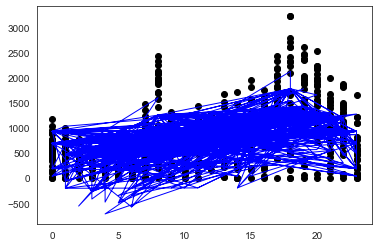

In [134]:
# Plot outputs
plt.scatter(test_x[criterio]['hour'].to_numpy(), test_y[index_list], color="black")
plt.plot(test_x[criterio]['hour'].to_numpy(), df_filtrado_pelo_criterio['quantidade'],color="blue", linewidth=1)

#plt.xticks(())
#plt.yticks(())

plt.show()

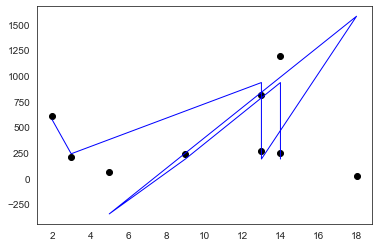

In [135]:
# Plot outputs
plt.scatter(test_x['hour'][1:10].to_numpy(), test_y[1:10], color="black")
plt.plot(test_x['hour'][1:10].to_numpy(), test_bike_seoul_pl_y[1:10],color="blue", linewidth=1)

#plt.xticks(())
#plt.yticks(())

plt.show()

In [ ]:
#Bora consertar estes números negativos... para isto vou aplicar a funão log de math

df['bicicletas'].apply(lambda x: math.log(x))

In [ ]:
import seaborn as sns
residuals = test_bike_seoul_pl_y- test_y
sns.scatterplot(data = residuals)
plt.xlabel("Data Instance")
plt.ylabel("Residual")
plt.show()



### Polynomial Regression

In [ ]:
class PolynomialRegression(BaseEstimator):
    '''
    '''
    def __init__(self, degree=2):
        self.degree = degree
        self.poly_reg_model = LinearRegression()
        
    def _generate_polynomial_features_(self, X):
        '''
        '''
        new_columns = []
        columns = list(X)
        for c in columns:
            for d in range(2, (self.degree+1)):
                new_c = str(c)+"^"+str(d)
                X[new_c]=pow(X[c],d)
        return X

    def fit(self, X, y=None):
        '''
        '''
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X = self._generate_polynomial_features_(X)
        self.poly_reg_model.fit(X,y)
        
    def predict(self, X):
        '''
        '''
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X = self._generate_polynomial_features_(X)
        return self.poly_reg_model.predict(X)
            

In [ ]:
poly_reg = PolynomialRegression(degree=11)
poly_lr_pl = Pipeline(steps = [('one_hot_encoder', CategoricalVaribleEncoder(categorical_features = categorical_columns)),
        ('scaler',StandardScaler()),
        ('poly_reg',poly_reg)
        
    ]
)

poly_lr_pl.fit(train_x,train_y)

In [ ]:
predited_poly_y = poly_lr_pl.predict(test_x)

In [ ]:
predited_poly_y

In [ ]:
test_y.to_numpy()

In [ ]:
r2_score(test_y.to_numpy(),predited_poly_y)

In [ ]:
train_predited_poly_y = poly_lr_pl.predict(train_x)

In [ ]:
r2_score(train_y.to_numpy(),train_predited_poly_y)

In [ ]:
# Plot outputs
plt.scatter((test_x['hour'][1:10]).to_numpy(), test_y[1:10], color="black")
plt.plot((test_x['hour'][1:10]).to_numpy(), test_bike_seoul_pl_y[1:10], color="blue", linewidth=1)

plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
#We have a problem of overfitting here as explained in page 118

## Lasso

In [ ]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()
lasso_bike_model_pl = Pipeline(steps = [('one_hot_encoder', CategoricalVaribleEncoder(categorical_features = categorical_columns)),
        ('scaler',StandardScaler()),
        ('lr',lasso_model)
        
    ]
)
lasso_bike_model_pl.fit(train_x,train_y)


In [ ]:
test_lasso_bike_y = lasso_bike_model_pl.predict(test_x)


In [ ]:
test_lasso_bike_y

In [ ]:
test_y

In [ ]:
r2_score(test_y.to_numpy(),test_lasso_bike_y)

In [ ]:
# Plot outputs
plt.scatter(list(test_x['hour'][1:10]), test_y[1:10], color="black")
plt.plot(list(test_x['hour'][1:10]), test_lasso_bike_y[1:10], color="blue", linewidth=1)

plt.xticks(())
plt.yticks(())

plt.show()

## DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt_bike_reg = DecisionTreeRegressor()
dt_bike_reg_pl = Pipeline(steps = [('one_hot_encoder', CategoricalVaribleEncoder(categorical_features = categorical_columns)),
        ('scaler',StandardScaler()),
        ('dt_reg',dt_bike_reg)
        
    ]
)

dt_bike_reg_pl.fit(train_x,train_y)

In [ ]:
predicted_bike_dt_reg_y =dt_bike_reg_pl.predict(test_x)
r2_score(test_y,predicted_bike_dt_reg_y)

In [ ]:
# Plot outputs
plt.scatter(list(test_x['hour'][1:10]), test_y[1:10], color="black")
plt.plot(list(test_x['hour'][1:10]), predicted_bike_dt_reg_y[1:10], color="blue", linewidth=1)

plt.xticks(())
plt.yticks(())

plt.show()

## SVM

In [ ]:


from sklearn.svm import LinearSVR

bike_svm_reg = LinearSVR(1.5)
bike_svm_reg_pl = Pipeline(steps = [('one_hot_encoder', CategoricalVaribleEncoder(categorical_features = categorical_columns)),
        ('scaler',StandardScaler()),
        ('SVM_reg',bike_svm_reg)
        
    ]
)

bike_svm_reg_pl.fit(train_x,train_y)

In [ ]:
predicted_bike_dt_svm_y =bike_svm_reg_pl.predict(test_x)
r2_score(test_y.to_numpy(),predicted_bike_dt_svm_y)

In [ ]:
test_y

In [ ]:
predicted_bike_dt_svm_y

In [ ]:
# Plot outputs
plt.scatter(test_x['hour'][1:10].to_numpy(), test_y[1:10], color="black")
plt.plot(test_x['hour'][1:10].to_numpy(), predicted_bike_dt_svm_y[1:10], color="blue", linewidth=1)

plt.xticks(())
plt.yticks(())

plt.show()

#### Support Vector Regression

In [ ]:
from sklearn.svm import SVR

bike_svm_reg_2 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
bike_svm_reg_pl_2 = Pipeline(steps = [('one_hot_encoder', CategoricalVaribleEncoder(categorical_features = categorical_columns)),
        ('scaler',StandardScaler()),
        ('SVM_reg_2',bike_svm_reg_2)
        
    ]
)

bike_svm_reg_pl_2.fit(train_x,train_y)

In [ ]:
predicted_bike_dt_svm_y_2 =bike_svm_reg_pl_2.predict(test_x)
r2_score(test_y.to_numpy(),predicted_bike_dt_svm_y_2)

In [ ]:
# Plot outputs
plt.scatter(test_x['hour'][1:10].to_numpy(), test_y[1:10], color="black")
plt.plot(test_x['hour'][1:10].to_numpy(), predicted_bike_dt_svm_y_2[1:10], color="blue", linewidth=1)

plt.xticks(())
plt.yticks(())

plt.show()

#### To do not affect the accuracy and also to not increase the complexity of our model unnecessary,we will chose the best features to work with.  
#### Building the Adjusted R2
 but the model R2 does not improve that much. It indicates the fact that some features may be irrelevant and are not influencing the determination of target variable value. Those can be excluded while building the final model. Adjusted R2